<a href="https://colab.research.google.com/github/ThuyLTN/ThucHanhCDTGMT/blob/master/exercise4_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive
!ls

/content/drive
'My Drive'


In [3]:
%cd My Drive
%cd ThucHanhCDTGMT

/content/drive/My Drive
/content/drive/My Drive/ThucHanhCDTGMT


In [40]:
!ls

abc.ipynb			 FaceDB      test_face.ipynb
ex2_23012019.ipynb		 Face_dt     Test_Faces
exercise_1_16012019.ipynb	 Face_noise  test.ipynb
exercise4_20022019.ipynb	 Face_rc     Untitled0.ipynb
exercise4_update_27022019.ipynb  Faces


In [51]:
!pip install mtcnn
!pip install face_recognition

    100% |████████████████████████████████| 2.3MB 13.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/be/dd/12/bccde6b95f576af24256f6f1a2e4087eb8488405a6c107e13c
Successfully built mtcnn


In [0]:
from mtcnn.mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import glob
import os
import face_recognition
import pickle
%matplotlib inline

In [0]:
def get_box(box):
  x = box[0]
  y = box[1]
  width = box[2]
  height = box[3]
  return x,y,width,height

In [0]:
def get_box_rc(box):
  top = box[0]
  right = box[1]
  bottom = box[2]
  left = box[3]
  return top, right, bottom, left

In [0]:
# transform MTCNN bounding box to face_recognition bounding box
def face_detect(image):
  face_bounds = []
  detector = MTCNN()
  detect_bound = detector.detect_faces(image)
  for index, face in enumerate(detect_bound):
    x,y,w,h = get_box(face['box'])
    top = y
    right = x+w
    bottom = y+h
    left = x
    a =(top, right, bottom, left)
    face_bounds.append(a)
  return face_bounds
    

In [0]:
def faceID_show(faceID_filenames):
  n = len(faceID_filenames)
  fig = plt.figure(figsize=(15,10))
  columns = 5
  rows = n//5 +1
  for i,filename in enumerate(faceID_filenames):
    list_image_filename = glob.glob(os.path.join(os.getcwd(), 'Face_rc/' + filename + '/*.png'))
    images = [cv2.imread(file) for file in list_image_filename]
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(filename)
    plt.imshow(images[0])
    plt.axis('off')
  plt.show()

In [0]:
# get test_image
list_test_img_filename = glob.glob(os.path.join(os.getcwd(), "Test_Faces/*.png"))
test_images = [cv2.imread(file) for file in list_test_img_filename]

In [0]:
def test_face(image, face_known_filenames):
  face_known_list = []
  # get all encoding of face_known
  for face_filename in face_known_filenames:
    with open(face_filename, 'rb') as file:
      face_known_list.append(pickle.load(file))
  
  # get bounding box and encoding of faces in image
  #face_bounds = face_recognition.face_locations(image, model = 'cnn')
  face_bounds = face_detect(image)
  face_encodings = face_recognition.face_encodings(image, known_face_locations = face_bounds, num_jitters=10)
  
  fig,ax = plt.subplots(figsize=(15,15))
  ax.imshow(image)
  
  FaceID_RC = []
  
  for index, bound in enumerate(face_bounds):
    top, right, bottom, left = get_box_rc(bound)
    rect = patches.Rectangle((left,top),right-left, bottom-top,linewidth=2,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    
    face_compares = face_recognition.compare_faces(face_known_list, face_encodings[index], tolerance= 0.4)
    a = np.array(face_compares)
    index_true = np.where(a==True)[0]
    length = len(index_true)
    
    if length==0:
      label = 'New_face'
    elif length==1:
      label = face_known_filenames[index_true[0]].split('/')[-2]
      FaceID_RC.append(label)
    else:
      foldernames = []
      for i in range(length):
        folder_filename_true = face_known_filenames[index_true[i]].split('/')[-2]
        foldernames.append(folder_filename_true)
      foldernames = set(foldernames)
      foldernames = list(foldernames)
      
      if len(foldernames)==1:
        label = foldernames[0]
        FaceID_RC.append(label)
      else:
        min_d = 0.41
        for i in range(length):
          encoding = face_known_list[index_true[i]]
          distance = face_recognition.face_distance([encoding], face_encodings[index])
          if distance < min_d:
            index_min = index_true[i]
            min_d = distance
        label = face_known_filenames[index_min].split('/')[-2]
        FaceID_RC.append(label)
    
    # draw label at image
    plt.text((left+right)//2, top, label, fontsize=15, color='r')
    
  plt.axis('off')
  plt.show()
  
  # return faceID for show image
  return FaceID_RC

In [0]:
# get face_encoding in dataset
face_known_filenames = glob.glob(os.path.join(os.getcwd(), 'Face_rc/*/*.pkl'))

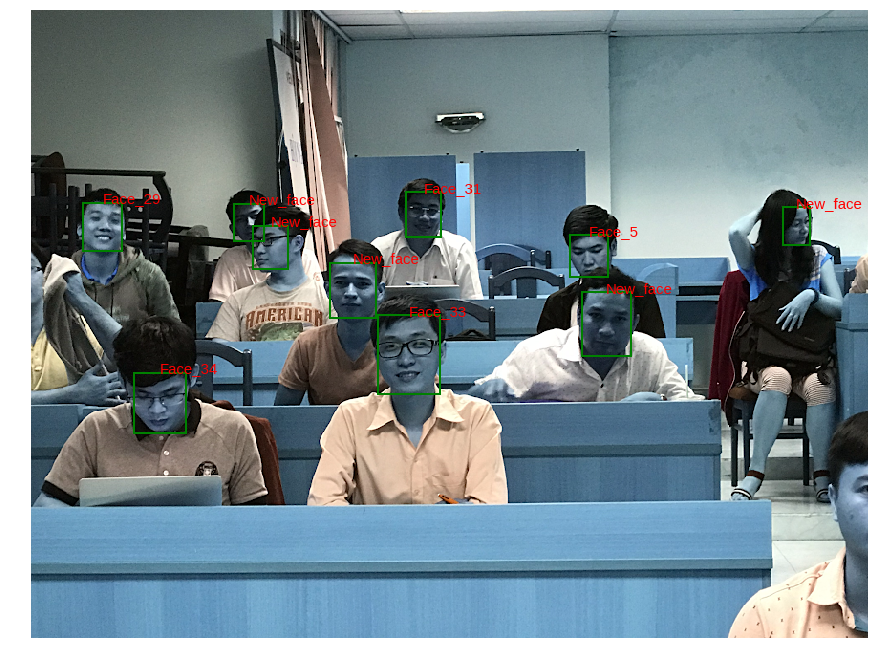

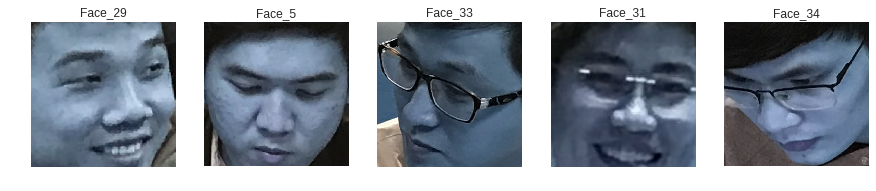

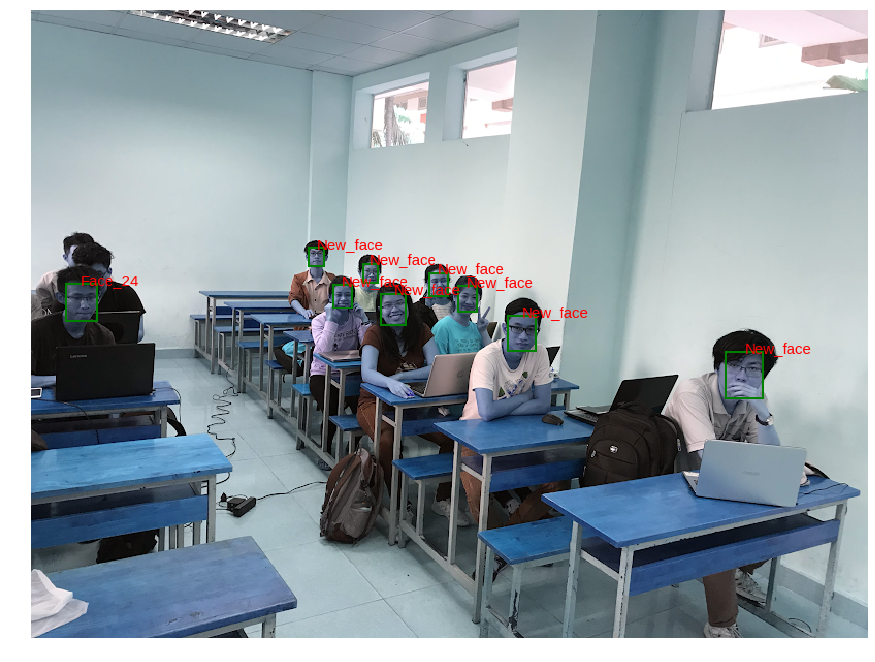

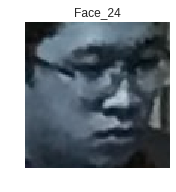

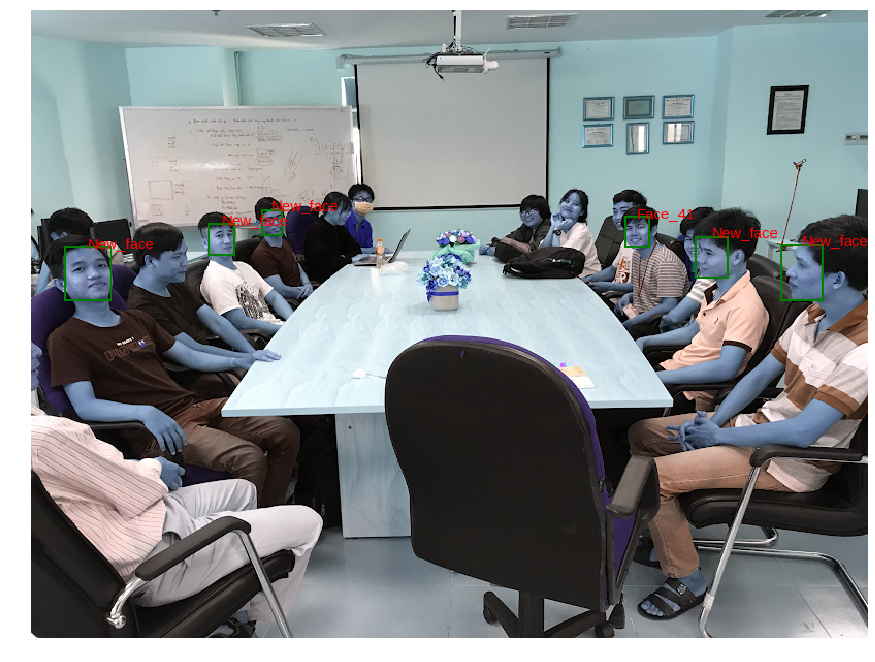

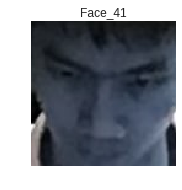

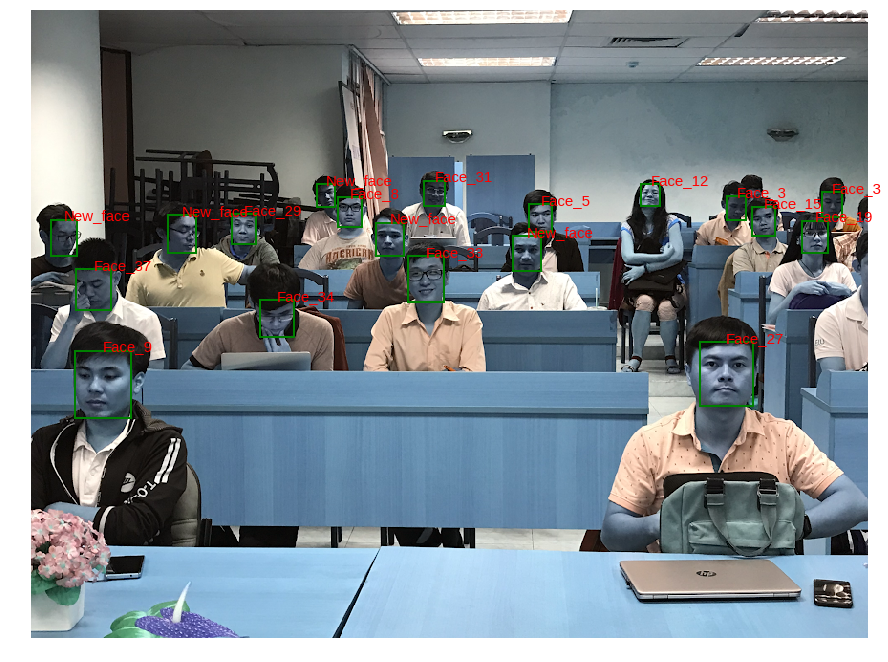

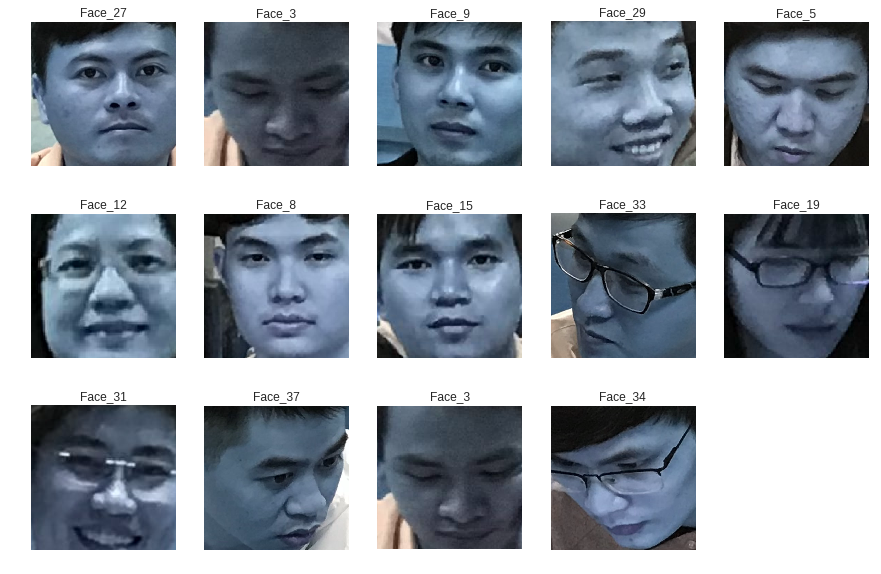

In [104]:
for image in test_images:
  faceID_RC = test_face(image, face_known_filenames)
  faceID_show(faceID_RC)